In [1]:
# 모듈 호출
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# 생성된 이미지 저장할 폴더
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")
# 시드값 고정
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# 생성자 구성
generator = Sequential()
generator.add(Dense(128*7*7, # 노드개수 128, 이미지 사이즈 7*7
                    input_dim=100, # 입력값의 차원, 임의지정
                    activation=LeakyReLU(0.2))) # relu는 학습이 불안정해지는 경우가 많아 leakyrelu 사용
generator.add(BatchNormalization()) # 입력데이터가 평균0, 분산1이 되도록 > 입력될 값들을 일정하게 재배치
generator.add(Reshape((7,7,128))) # 이미지 사이즈 7*7 > 2번의 업샘플링 후 원본 이미지와 사이즈 동일하도록
generator.add(UpSampling2D())
generator.add(Conv2D(64, # 필터 개수
                     kernel_size=5, # 필터 사이즈 5*5
                     padding='same')) # 패딩 수행, 출력 후에도 사이즈 유지
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2))) # 0아래에서 0이 아니라 0.2를 곱해서 전달함
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=3, padding='same', activation='tanh')) # 활성화함수 tanh 사용(-1~1)

In [3]:
# 판별자 구성 > 기존 CNN의 역할과 차이가 없음 > 진짜/가짜 이진분류
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable=False # 판별자의 학습을 방지

In [4]:
# 모델 구성
ginput = Input(shape=(100,)) # 생성자에서 지정한 차원수
dis_output = discriminator(generator(ginput)) # 생성자로 생성된 데이터를 판별한 결과

gan = Model(ginput, dis_output) # 각각을 입력과 출력으로 가지는 모델 정의
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         864257    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,077,122
Trainable params: 851,585
Non-trainable params: 225,537
_________________________________________________________________


11501568/11490434 [==============================] - 0s 0us/step
epoch:0  d_loss:0.7003  g_loss:0.5094
epoch:1  d_loss:0.4826  g_loss:0.3117
epoch:2  d_loss:0.3961  g_loss:0.1332
epoch:3  d_loss:0.3600  g_loss:0.0554
epoch:4  d_loss:0.3739  g_loss:0.0210
epoch:5  d_loss:0.4326  g_loss:0.0132
epoch:6  d_loss:0.5389  g_loss:0.0251
epoch:7  d_loss:0.6006  g_loss:0.1007
epoch:8  d_loss:0.4892  g_loss:0.5526
epoch:9  d_loss:0.5821  g_loss:0.5921
epoch:10  d_loss:0.5893  g_loss:0.4229
epoch:11  d_loss:0.5058  g_loss:0.3444
epoch:12  d_loss:0.4528  g_loss:0.3554
epoch:13  d_loss:0.3792  g_loss:0.4560
epoch:14  d_loss:0.3311  g_loss:0.6606
epoch:15  d_loss:0.2725  g_loss:0.9725
epoch:16  d_loss:0.2320  g_loss:1.2898
epoch:17  d_loss:0.1889  g_loss:1.4802
epoch:18  d_loss:0.1807  g_loss:1.0587
epoch:19  d_loss:0.1531  g_loss:0.9654
epoch:20  d_loss:0.1596  g_loss:1.0338
epoch:21  d_loss:0.2284  g_loss:1.0449
epoch:22  d_loss:0.1470  g_loss:1.4182
epoch:23  d_loss:0.1863  g_loss:1.0113
epoch:24 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


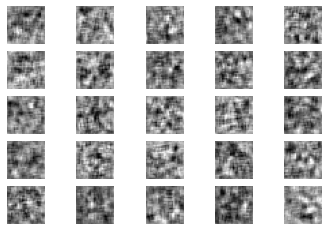

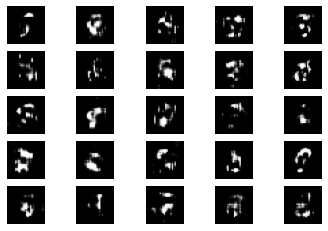

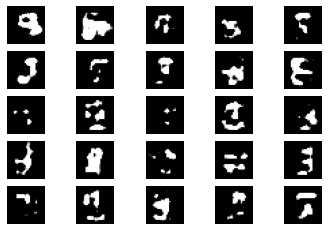

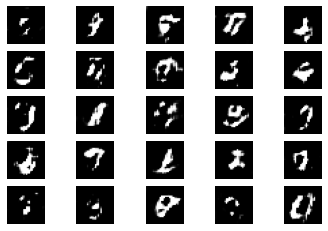

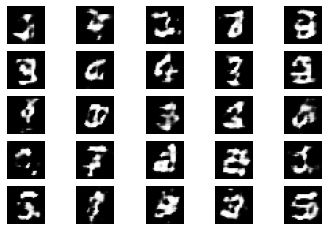

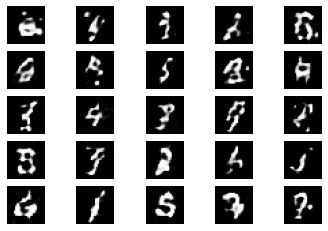

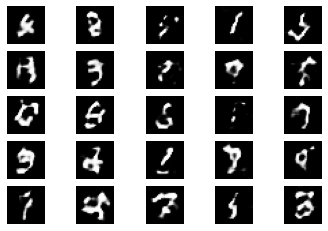

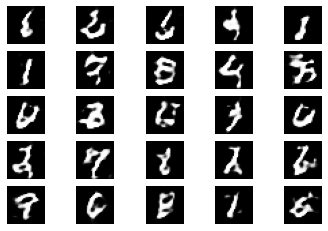

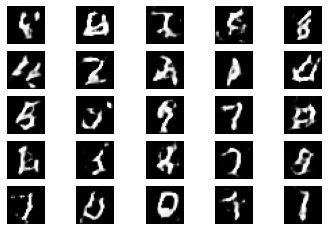

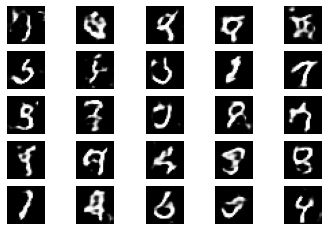

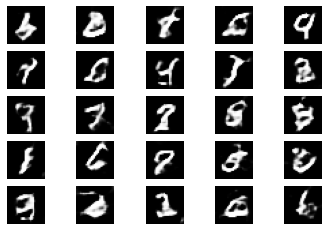

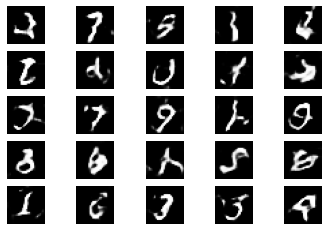

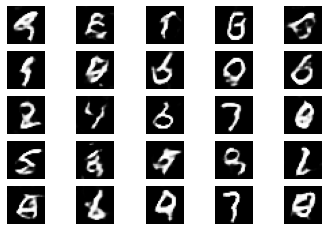

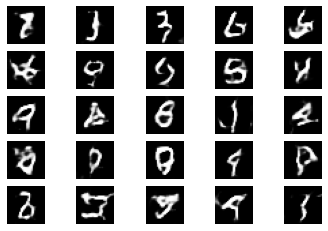

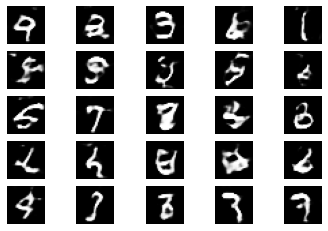

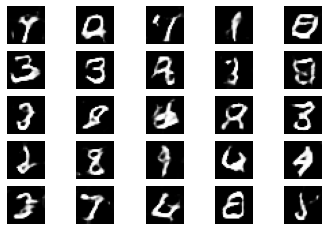

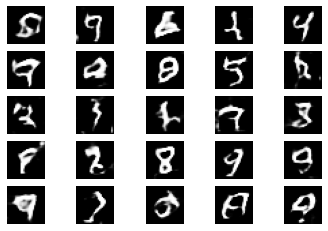

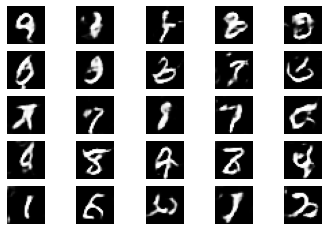

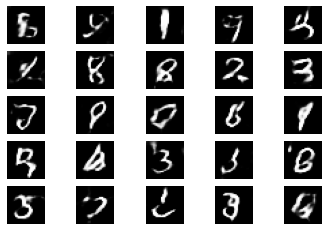

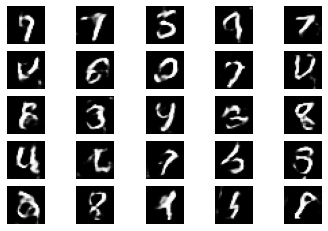

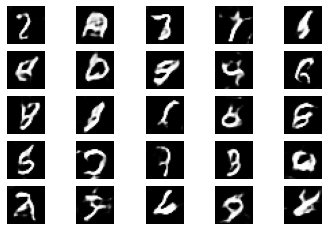

In [5]:
# 실행 함수 정의
def gan_train(epoch, batch_size, saving_interval):
    # 사용할 데이터 불러오기
    (X_train,_),(_,_) = mnist.load_data() # 주어진 라벨 데이터를 이용해 학습하고 분류하는게 아님
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_train = (X_train - 127.5) / 127.5  #  -1~1사이의 값으로 변경
    
    # 이미지 진위 여부에 지정될 라벨
    true = np.ones((batch_size, 1)) 
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        # 실제 데이터를 판별자에 입력
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 임의로 가져올 이미지의 인덱스
        img = X_train[idx] # 해당 인덱스의 이미지
        d_loss_real = discriminator.train_on_batch(img, true)
        
        # 생성자로 생성된 이미지를 판별자에 입력
        noise = np.random.normal(0,1,(batch_size,100)) # 노이즈 생성
        gen_imgs = generator.predict(noise) # 노이즈로부터 이미지 생성
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        
        # 중간 과정 이미지 저장
        if i % saving_interval == 0 :
            noise = np.random.normal(0,1,(25,100))
            gen_imgs = generator.predict(noise)
            
            gen_imgs = 0.5 * gen_imgs + 0.5 # 0~1로 다시 스케일링

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("gan_images/gan_mnist_%d.png" % i)
gan_train(4001, 32, 200)  
# 4000번 반복되고(+1 해 주는 것 주의), 배치 사이즈 32,  200번 마다 결과 저장